# Présentation du modèle de l'équipe MIA

## Résumé

Nous avons choisit de modéliser les systèmes étudiés par des systèmes LTI.
Ce notebook présente dans un premier temps l'évolution de nos stratégie et justifie le choix du modèle finale basé sur ses performances.

Deuxièmement, nous évaluons le modèle final avec les métriques du challenge.


## Evolution des stratégies

### Les systèmes LTI

Un système linéaire et invariant dans le temps (LTI) à une entrée et une sortie peut être décrit mathématiquement par une équation différentielle à coefficient constant liant l'entrée du système et sa sortie. Ainsi, 

$$a_N\frac{d^N y(t)}{dt^N}+\cdots+a_1\frac{d y(t)}{dt}+a_0y(t)=b_N\frac{d^N x(t)}{dt^N}+\cdots+b_1\frac{d x(t)}{dt}+b_0 x(t)$$

où $x(t)$ désigne l'entrée du système et $y(t)$ sa sortie et $N$ correspond à l'ordre du système. Pour analyser ces systèmes, une technique couramment utilisée consiste à passer dans le domaine de Laplace. Notons $X(p)=\mathcal{L}[x(t)]$ et $Y(p)=\mathcal{L}[y(t)]$ les transformées de Laplace de l'entrée et de la sortie. En utilisant le fait que la transformée de Laplace est linéaire et que $\mathcal{L}[\frac{d^k e(t)}{dt^k}]=p^k E(p)$, il est possible de décrire la système par la fonction suivante

$$H(p)\triangleq \frac{Y(p)}{X(p)}=\frac{b_N s^N+b_{N-1}p^{N-1}+\cdots+b_1 p+b_0}{a_N p^N+a_{N-1}p^{N-1}+\cdots+a_1 p+a_0}$$

Cette fonction est appelée **fonction de transfert** du système. D'un point de vue mathématique, à l'exception des systèmes possédant un ordre faible, il est souvent plus pratique d'analyser un système dans le domaine de Laplace plutôt que dans le domaine temporel.

Le langage Python permet de créer des fonctions de transfert via la classe `lti` du module `signal` de Scipy. Cette classe prend deux tableaux en entrée: un tableau contenant les coefficients du numérateur et un tableau contenant les coefficients du dénominateur. 

On va approcher les réponses des 5 systèmes par des réponses de modèles LTI, pour se faire, on va optimiser les coefficients $(a_0,...,a_N,b_0,...,b_N)$ pour approcher au moins la réponse des systèmes.



La partit Initialisation est nécessaire à la suite du notebook. \
Les parties 'Stratégie _' sont indépendantes les unes des autres et peuvent ne pas être excecutées.

### Initialisation

Modules et fonctions nécessaires a la première partie du notebook

In [5]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator
from scipy.optimize import minimize
import scipy.signal as sig
from scipy.optimize import least_squares, minimize

import time
from tqdm import notebook
import importlib

from sklearn.metrics import mean_absolute_error

from numpy import linalg as la

import sys
from importlib import reload,import_module
import os

#import sagemaker
#import boto3

%matplotlib inline

import copy

#from sources.utilities.utility_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'google'

In [2]:
def pred(x, t_e, entree):
    """
    Gives the response of a LTI system
    - at times t_e 
    - given an imput signal entree
    - given coefficients x
    """
    b = x[:int(len(x)/2)]
    a = x[int(len(x)/2):]
    H_1 = sig.lti(b,a)
    [t_s, sortie, xout] = H_1.output(entree,t_e)
    return sortie

def err(x, t, entree, y):
    """ Computes the squared error between truth and prediction """
    return (pred(x, t, entree) - y)**2

def err_multi(x, times, entrees, outputs):
    """ Computes the squared error between truth and prediction at multiple times """
    error = 0
    for k in range(len(entrees)) :
        error += np.mean(err(x,times[k],entrees[k],outputs[k]))
    return error 

def RMSE(real,prediction):
    """ Computes the mean squared error between truth and prediction """
    rmse = 0
    for k in range(len(real)):
        rmse += (real[k]-prediction[k])**2
    return rmse/len(real)

#### Chargement des données : 

In [3]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(0,7)]  

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)

columns_titles = ['Time','Output1','Input','Output2','Output3','Output4','Output5']

for name in names:
    d[name].columns = columns_titles
    d[name] = d[name][['Time','Input','Output1','Output2','Output3','Output4','Output5']]

#### Tracé des inputs et des outputs :

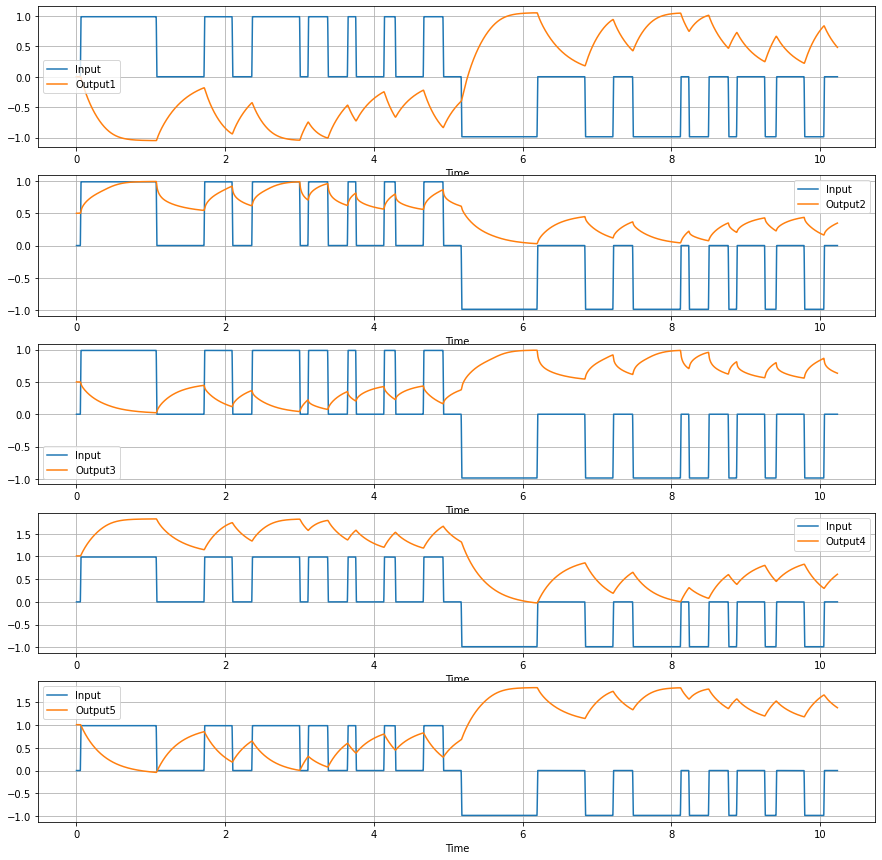

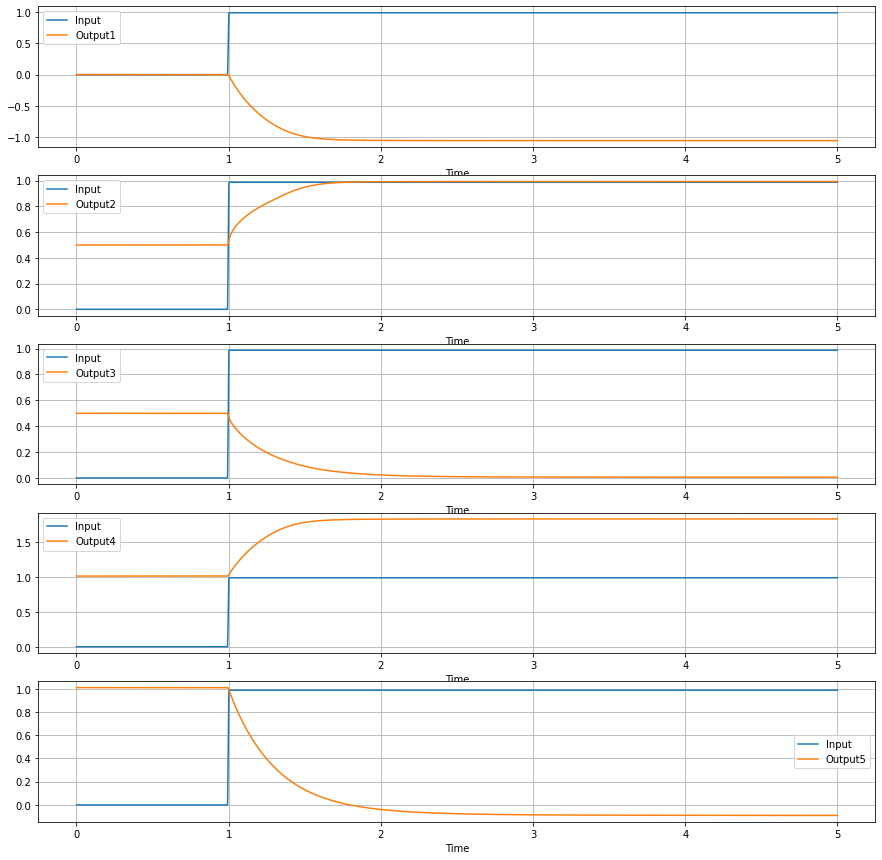

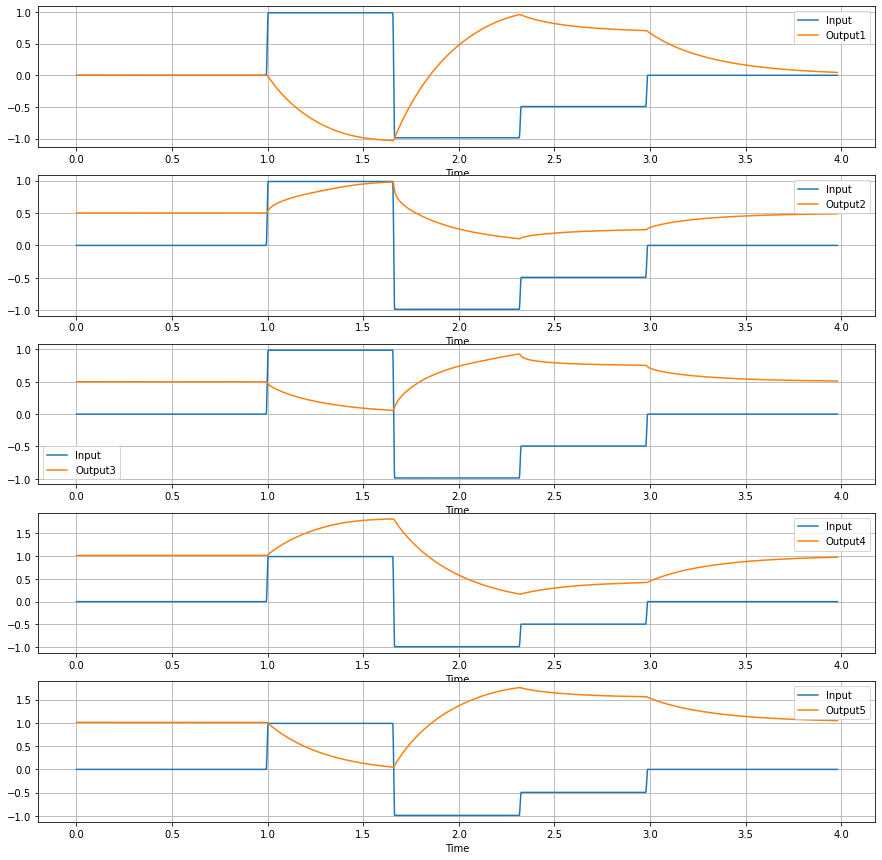

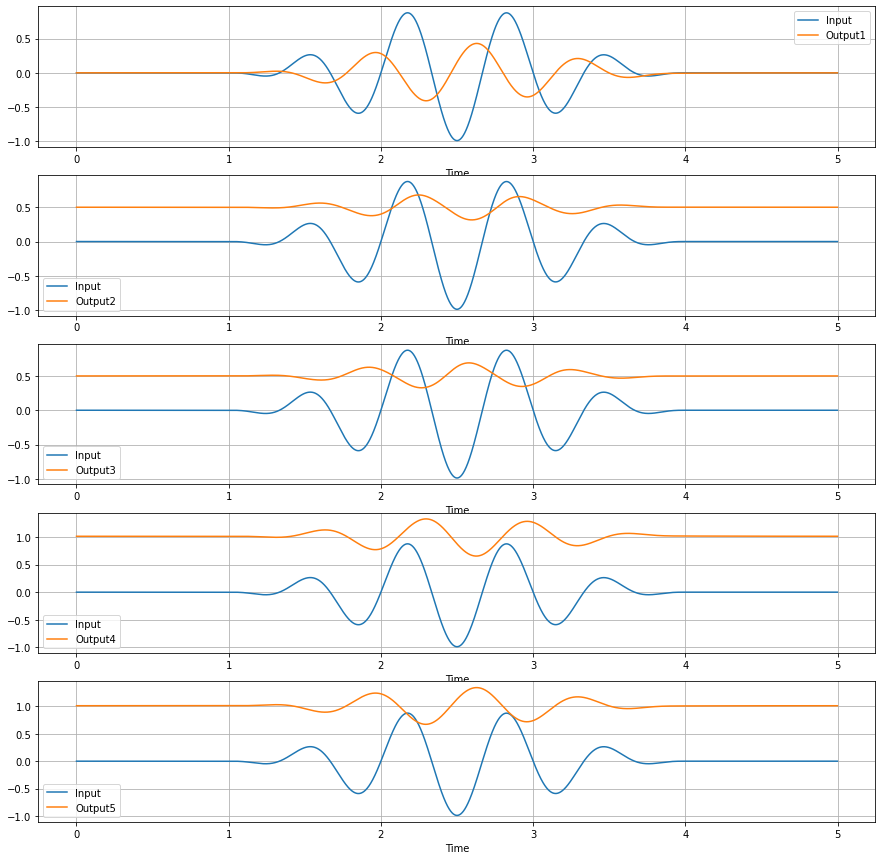

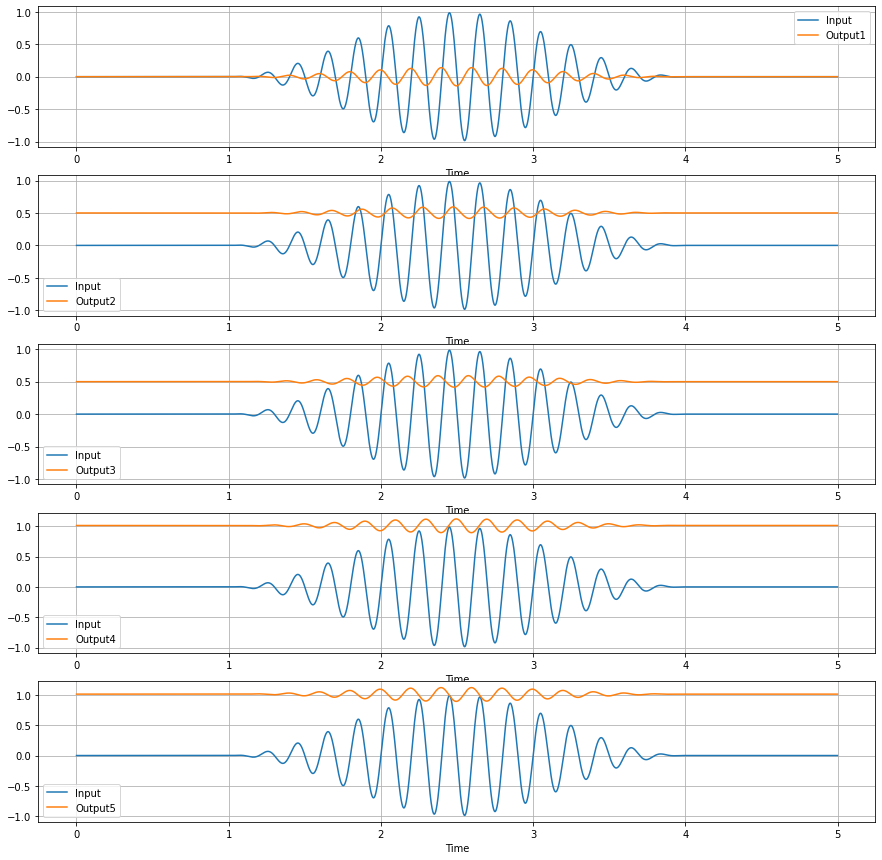

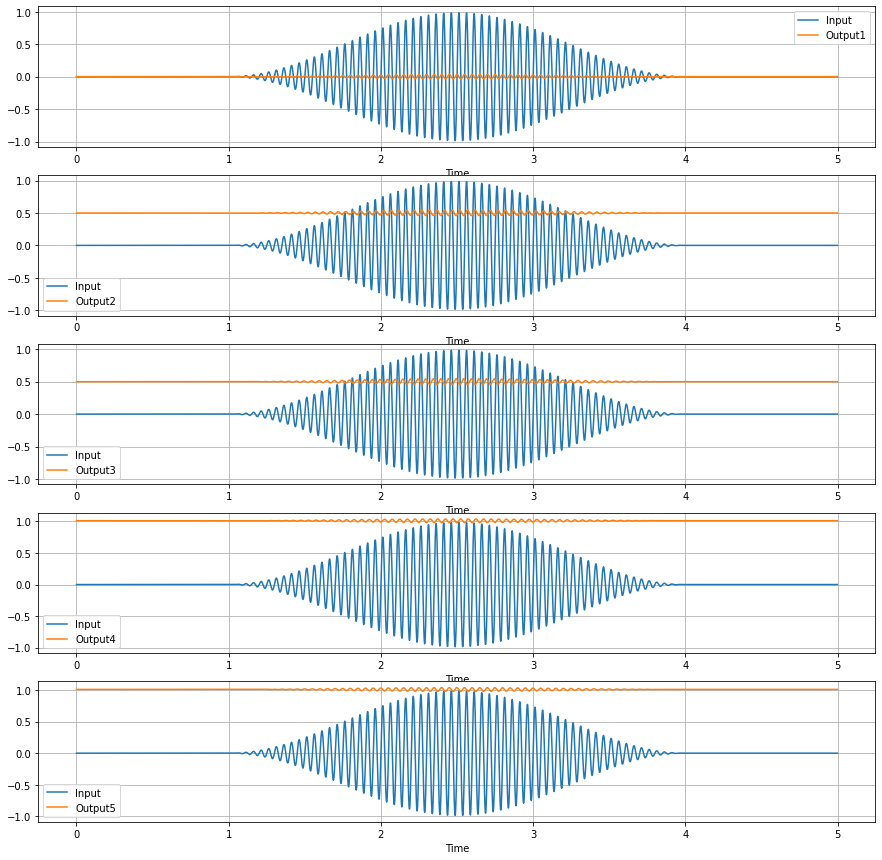

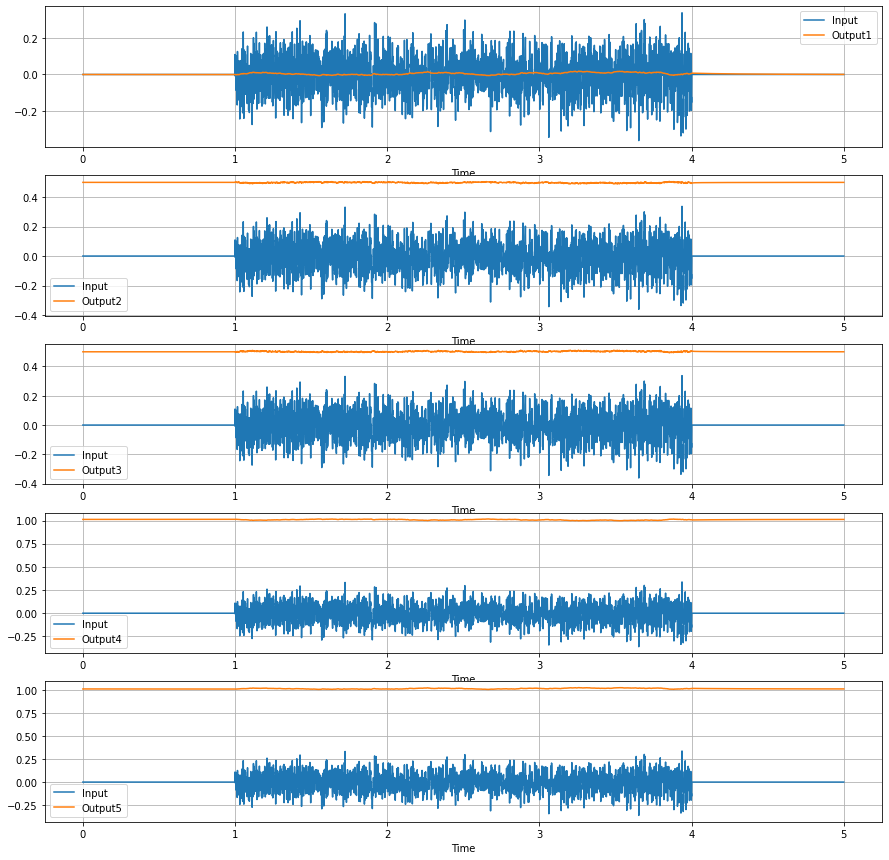

In [4]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

Il est nécessaire de standardiser les Outputs pour utiliser les modules scipy LTI, on supprime l'offset et on normalise à 1 les Output

#### Calcul des shrink (positif ou négatif) et des offset de chaque output :

In [5]:


Output_names = ['Output1','Output2','Output3','Output4','Output5']
Output_correction = {'Output1':[0,0],'Output2':[0,0],'Output3':[0,0],'Output4':[0,0],'Output5':[0,0]}
for name in Output_names:
    offset = d['input0'][name][1]
    Output_correction[name][0] = offset
    
    shrink = (d['input1'][name][5000]-offset)/d['input1']['Input'][5000]
    Output_correction[name][1] = shrink

#### Traitement des output :

In [6]:
d_corrige = copy.deepcopy(d)
    
for key in d_corrige.keys():
    for name in Output_names:
        d_corrige[key][name] = d[key][name] - Output_correction[name][0] 
        d_corrige[key][name] = 1/Output_correction[name][1]*d_corrige[key][name]

#### Tracé des inputs et des Outputs corrigés :

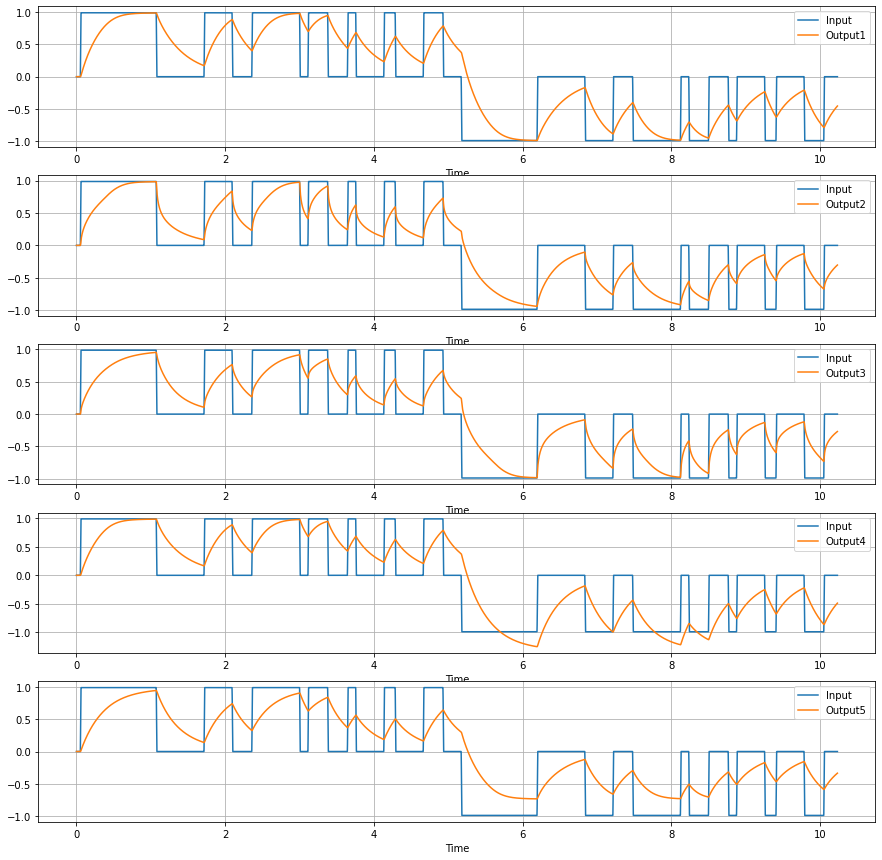

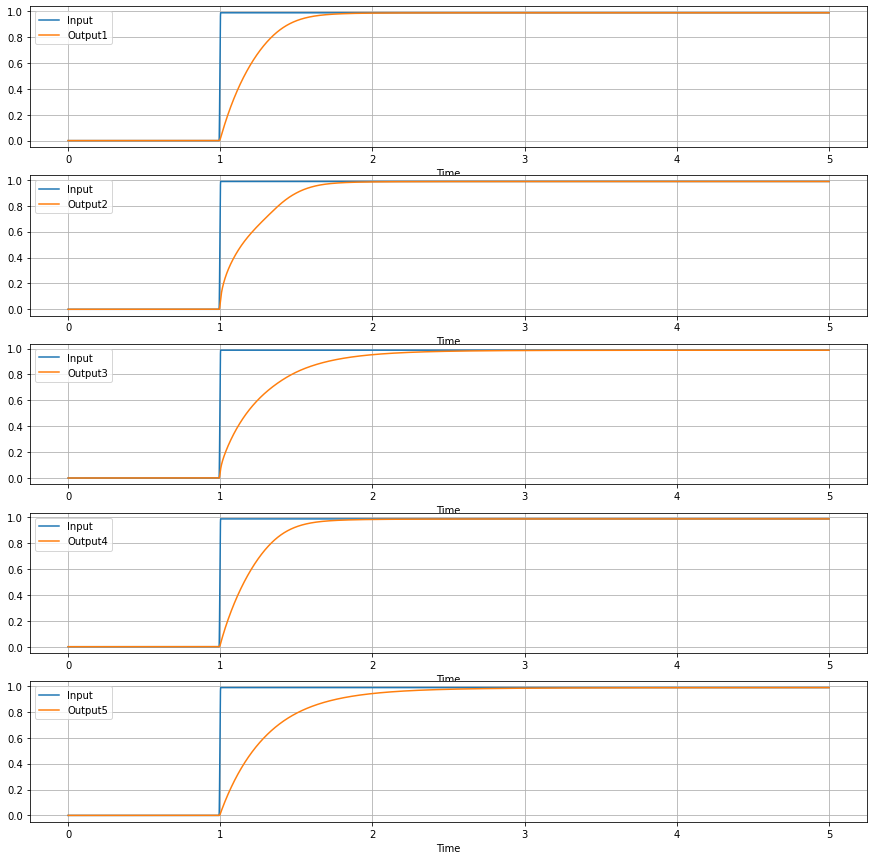

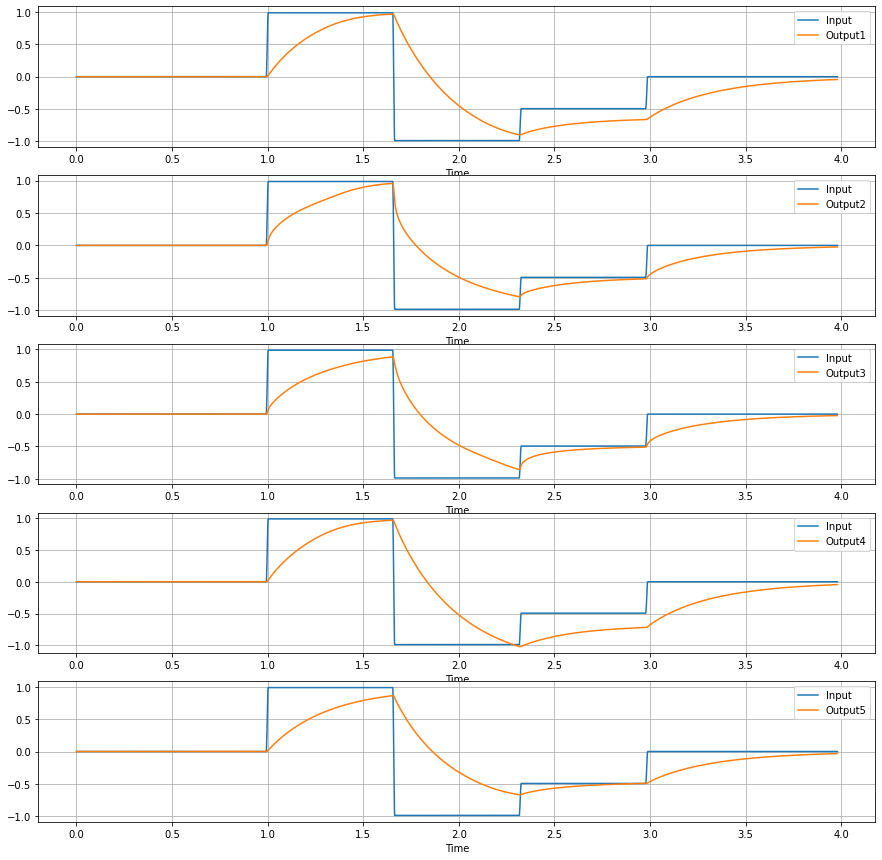

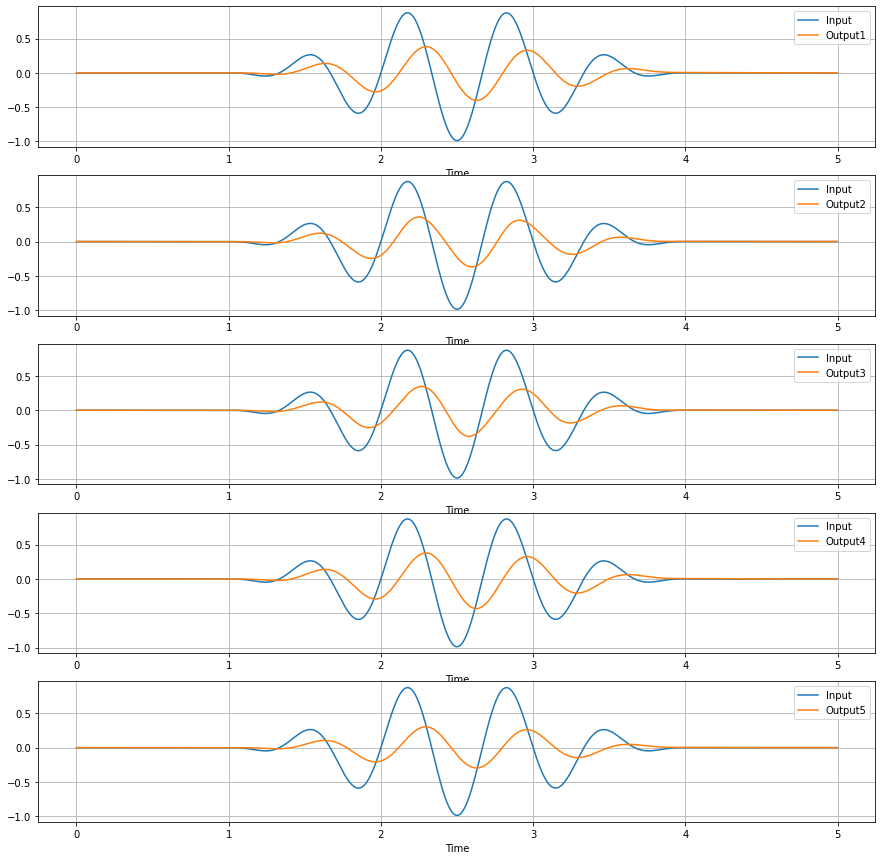

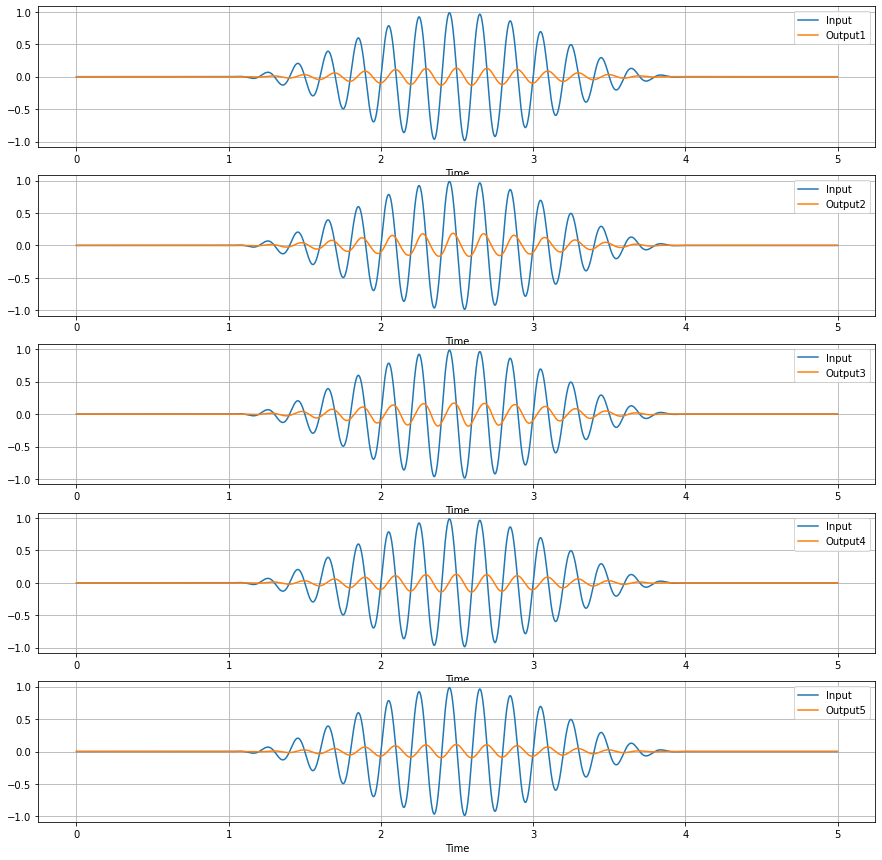

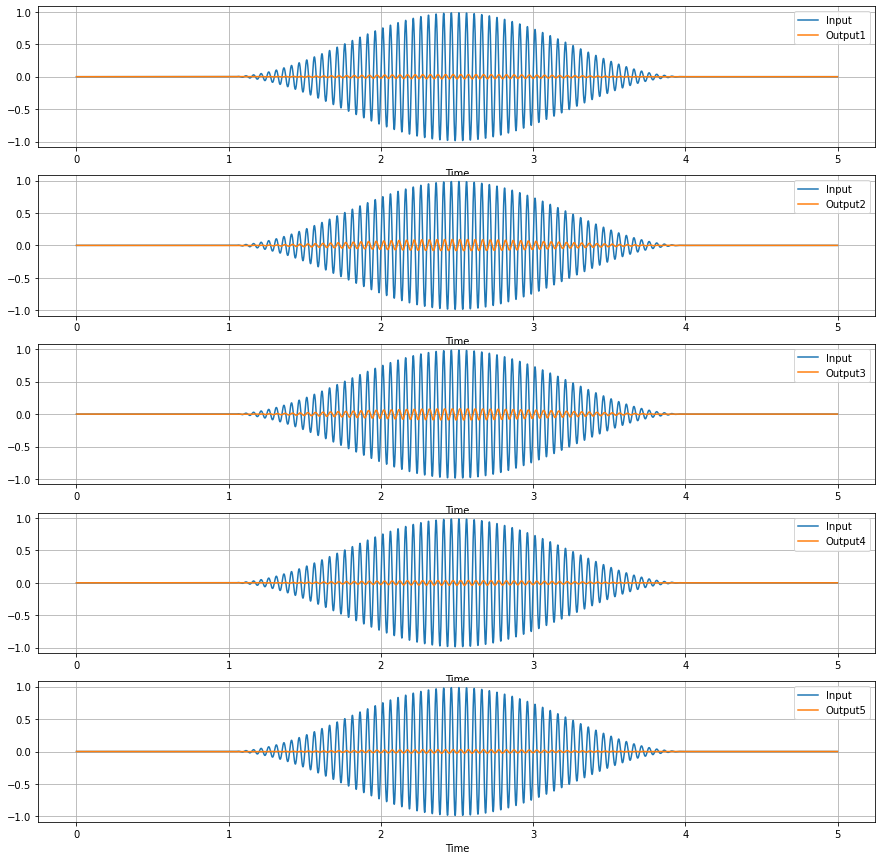

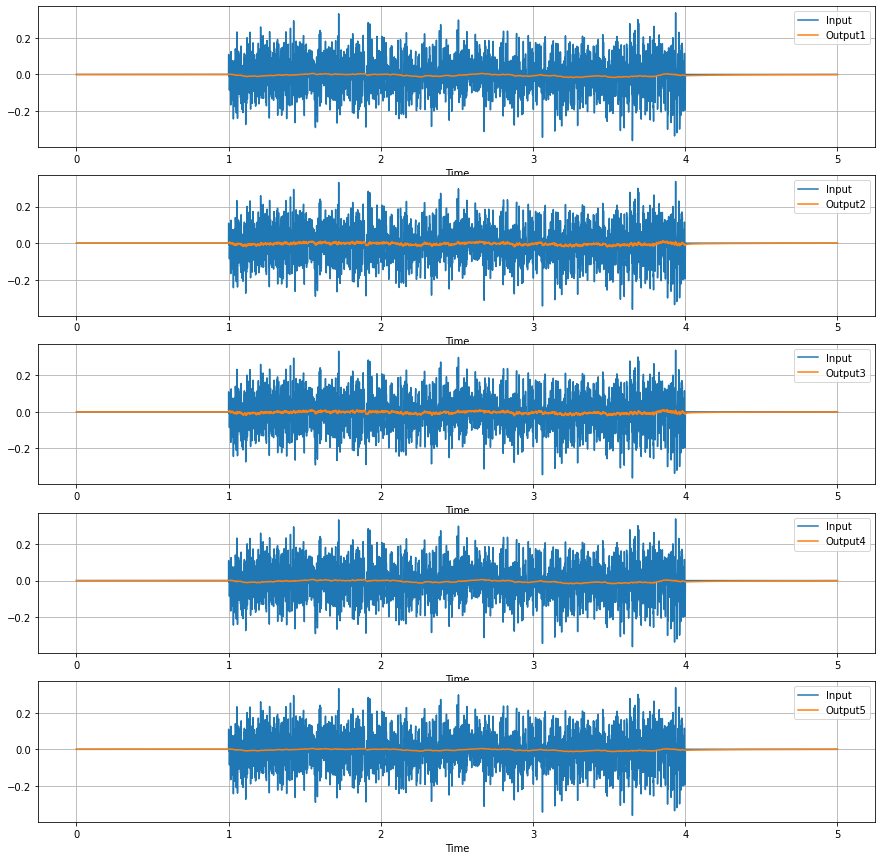

In [7]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    _,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d_corrige[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

### Stratégie 1 : Calcul des coefficients des systèmes LTI basé sur un seul input

Pour un input choisit arbitrairement, on approxime les coefficients de la fonctions de transfert de degré $N$ dont la réponse approche le mieux celle de chacun des systèmes. On calcule ainsi 5 liste de $2N$ coefficients.

#### Calcul des coefficients :

In [ ]:
input_train = "input0"   ##On choisit ici l'input sur lequel on calcule les coefficients de la fonction de transfert
params_output = {}
Compteur = 0
N_total = len(Output_names)
degre = 3  ###degré N

print("Avancement : 0%")

for name in Output_names:
    
    Time = d[input_train]['Time']
    Input = d[input_train]['Input']
    Output = d_corrige[input_train][name]
    
    ##Calcul des paramètre à un degré donné
    x0 = np.ones(2*degre)
    x = np.arange(1,2*degre+1)

    res = least_squares(err, x0, bounds=(-3, 3), args=(Time,Input, Output), verbose=0, ftol=1e-15, gtol=1e-15, xtol = 1e-15)
    x = res.x
    
    Compteur += 1
    print("Avancement : " + str(round(Compteur/N_total*100)) + "%")

    params_output[name] = x

Avancement : 0%
Avancement : 20%
Avancement : 40%
Avancement : 60%
Avancement : 80%


#### Calcul des sorties :

On calcule les sorties de notre modèle sur chacun des inputs comme la réponse des systèmes LTI approchés juste avant. 

In [ ]:
Sorties = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        
        x = params_output[name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties[key][name+"_approx"] = sortie
    
    Sorties[key] = pd.DataFrame(Sorties[key])

#### Tracé des sorties calculées et des sorties réelles : 

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

#### RMSE pour chacun des signaux :

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse_test = 0
mean_rmse_train = 0 
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties[name][Output_names[k]],Sorties[name][Output_names[k]+"_approx"])
        mean_rmse_train += rmse*(name == input_train)/(5*1)
        mean_rmse_test += rmse*(name != input_train)/(5*6)
        mean_rmse += rmse/(5*7)
        print(name)
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Input d'entrainement : " + str(name == input_train))
        print("-----------------")
        
print("RMSE moyenne sur echantillon entrainement : " + str(mean_rmse_train) )
print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )
print("RMSE moyenne : " + str(mean_rmse) )

Essayons de changer l'input pour lequel on caclcule les coefficients et répétons le processus :

In [ ]:
input_train = "input3"   ##On choisit ici l'input sur lequel on calcule les coefficients de la fonction de transfert
params_output = {}
Compteur = 0
N_total = len(Output_names)
degre = 3  ###degré N

print("Avancement : 0%")

for name in Output_names:
    
    Time = d[input_train]['Time']
    Input = d[input_train]['Input']
    Output = d_corrige[input_train][name]
    
    ##Calcul des paramètre à un degré donné
    x0 = np.ones(2*degre)
    x = np.arange(1,2*degre+1)

    res = least_squares(err, x0, bounds=(-3, 3), args=(Time,Input, Output), verbose=0, ftol=1e-15, gtol=1e-15, xtol = 1e-15)
    x = res.x
    
    Compteur += 1
    print("Avancement : " + str(round(Compteur/N_total*100)) + "%")

    params_output[name] = x
    

Sorties = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        
        x = params_output[name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties[key][name+"_approx"] = sortie
    
    Sorties[key] = pd.DataFrame(Sorties[key])
    
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')
        
                
mean_rmse_test = 0
mean_rmse_train = 0 
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties[name][Output_names[k]],Sorties[name][Output_names[k]+"_approx"])
        mean_rmse_train += rmse*(name == input_train)/(5*1)
        mean_rmse_test += rmse*(name != input_train)/(5*6)
        mean_rmse += rmse/(5*7)
        print(name)
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Input d'entrainement : " + str(name == input_train))
        print("-----------------")
        
print("RMSE moyenne sur echantillon train : " + str(mean_rmse_train) )
print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )
print("RMSE moyenne : " + str(mean_rmse) )

Ici, quelques prédictions sont très mauvaises alors qu'elles ne l'étaient pas avant, on constate malgré ça une amélioration sur l'input d'entrainement. Finalement, les approximations du premier processus étaient probablement bonnes par chance. 
Calculons des coefficients pour chacun des inputs.

On introduit la métrique suivante :

$$\sum_{i,j} RMSE(\hat{O}_{i,j}, O_{i,j}),$$

où $O_{i,j}$ est l'output du système $j$ sur l'input $I_i$ et $\hat{O}_{i,j}$ est cet output approché.

Avec $\hat{O}_{i,j}$ calculé avec les coefficients calculé sur un input $I_k$ où $k \neq i$. Ne sachant pas comment choisir l'indice $k$, on définit $\hat{O}_{i,j}$ comme la moyenne empirique suivante :
$$\hat{O}_{i,j} = \frac{1}{N_{inp}-1}\sum_{k \neq i} \hat{R}_{k,j}(I_i),$$

où $\hat{R}_{k,j}$ est la fonction réponse du système linéaire $j$ approché par minimisation sur l'input $I_k$.

#### Calcul de tous les coefficients

Le calcul ci dessous est un peu plus long, il dure environ 10 minutes

In [ ]:
N_total = len(Output_names)*len(d.keys())
degre = 3  ###degré N

params_output = {}
Compteur = 0

print("Avancement : 0%")

for key in d.keys() : 
    params_output[key] = {}
    for name in Output_names :
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d_corrige[key][name]

        ##Calcul des paramètre à un degré donné
        x0 = np.ones(2*degre)
        x = np.arange(1,2*degre+1)

        res = least_squares(err, x0, bounds=(-3, 3), args=(Time,Input, Output), verbose=0, ftol=1e-15, gtol=1e-15, xtol = 1e-15)
        x = res.x

        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) + "%")

        params_output[key][name] = x

#### Calcul de toutes les sorties

In [ ]:
Sorties = copy.deepcopy(d)
print("Avancement : 0%")
Compteur = 0

for key in d.keys():
    for name in Output_names:
        Inputs_calcul = []
        for inp in d.keys() : 
            if inp != key : Inputs_calcul.append(inp)
        
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        Sorties[key][name+"_approx"] = 0
        
        for inp in Inputs_calcul :
            x = params_output[inp][name]
            sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
            Sorties[key][name+"_approx"] += sortie/len(Inputs_calcul)
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) + "%")        
    
    Sorties[key] = pd.DataFrame(Sorties[key])

#### Tracés et calcul de l'erreur

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')
        
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties[name][Output_names[k]],Sorties[name][Output_names[k]+"_approx"])
        mean_rmse += rmse/(5*7)
        
print("RMSE moyenne : " + str(mean_rmse) )

Les prédictions sont très mauvaises, sauf dans de rares cas, cependant cette méthode n'est pas à jeter, on a vu de bons résultats quand on choisissait bien l'input.

## Stratégie 2 : Calcul des coefficients en minimisant l'erreur moyenne des réponses sur plusieurs inputs

On calcules les coefficients en minimisant l'erreur moyenne entre la réponse du LTI et la réponse réelle sur un échantillon d'entrainement et on le test sur un autre échantillon.

In [ ]:
inputs_train = ['input0','input1','input3','input5']
inputs_test = ['input2','input4','input6']

entrees_train = [d[key]['Input'] for key in inputs_train]
times_train = [d[key]['Time'] for key in inputs_train]
params_output_2 = {} 
degre = 3
N_total = len(Output_names)
Compteur = 0
print("Avancement : 0%")

for name in Output_names:
    outputs = [d_corrige[key][name] for key in inputs_train]
    
    x0 = np.ones(2*degre)
    x = np.arange(1,2*degre+1)

    res = least_squares(err_multi, x0, bounds=(-3, 3), args=(times_train,entrees_train,outputs), verbose=1, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 50)
    x = res.x

    Compteur += 1
    print("Avancement : " + str(round(Compteur/N_total*100)) +"%")
        
    params_output_2[name] = x

#### Calcul des sorties

In [ ]:
Sorties_v2 = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        
        x = params_output_2[name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties_v2[key][name+"_approx"] = sortie
    
    Sorties_v2[key] = pd.DataFrame(Sorties_v2[key])

#### Tracés sur des prédicitions sur l'échantillon d'entrainement 

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs_train:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v2[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

#### Tracés sur des prédicitions sur l'échantillon de test

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs_test:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v2[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

#### RMSE pour chacun des signaux

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse_test = 0
mean_rmse_train = 0 
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v2[name][Output_names[k]],Sorties_v2[name][Output_names[k]+"_approx"])
        mean_rmse_train += rmse*(name in inputs_train)/(5*len(inputs_train))
        mean_rmse_test += rmse*(name in inputs_test)/(5*len(inputs_test))
        mean_rmse += rmse/(5*len(names))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Input d'entrainement : " + str(name in inputs_train))
        print("-----------------")

        
print("RMSE moyenne sur echantillon train : " + str(mean_rmse_train) )
print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )
print("RMSE moyenne : " + str(mean_rmse) )

Les résultats semblent nettement meilleurs qu'avant, on a peut-être eu de la chance sur notre échantillon de test comme avant.

Comme précedemment, on va calculer l'erreur générale :
$$\sum_{i,j} RMSE(\hat{O}_{i,j}, O_{i,j}),$$

où cette fois $\hat{O}_{i,j}$ est définit par :
$$\hat{O}_{i,j} = \hat{R}_{*,j}(I_i),$$

avec $\hat{R}_{*,j}$ la réponse du système LTI approché en minimisant l'erreur moyenne sur tous les inputs $I_k$, $k \neq j$.

#### Calcul de tous les coefficients

Calculs d'une durée d'environ 1 heure (en local)

In [ ]:
N_total = len(Output_names)*len(d.keys())
degre = 3  ###degré N

params_output_2 = {}
Compteur = 0

print("Avancement : 0%")

for key in d.keys() : 
    params_output_2[key] = {}
    for name in Output_names :
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d_corrige[key][name]
        inputs_train = []
        for inp in d.keys():
            if inp != key :
                inputs_train.append(inp)
        
        entrees_train = [d[inp]['Input'] for inp in inputs_train]
        times_train = [d[inp]['Time'] for inp in inputs_train]
        outputs = [d_corrige[inp][name] for inp in inputs_train]

        ##Calcul des paramètre à un degré donné
        x0 = np.ones(2*degre)
        x = np.arange(1,2*degre+1)

        res = least_squares(err_multi, x0, bounds=(-3, 3), args=(times_train,entrees_train,outputs), verbose=0, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 50)
        x = res.x

        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) + "%")

        params_output_2[key][name] = x
             

#### Calcul des sorties

In [ ]:
Sorties_v2 = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        
        x = params_output_2[key][name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties_v2[key][name+"_approx"] = sortie
    
    Sorties_v2[key] = pd.DataFrame(Sorties_v2[key])

#### Tracés et calcul de l'erreur générale

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v2[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')
        
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v2[name][Output_names[k]],Sorties_v2[name][Output_names[k]+"_approx"])
        mean_rmse += rmse/(5*7)
        
print("RMSE moyenne : " + str(mean_rmse) )

On obtient une erreur générale de : $0.00331$ \
Cette fois ci, aucune prédicition n'est très mauvaise, l'ensemble est bien meilleur que pour la première stratégie.

## Stratégie 3 : Agrégation des sorties prédites par similitude des inputs

Comme dans la première stratégie, on va calculer les coefficients pour chacun des systèmes et des inputs disponibles. Plutôt que de moyenne la prédicition de chacuns des systèmes LTI on va pondérer la somme en fonction d'une similitude entre deux inputs $I_1$ et $I_2$ qu'on définie par :
$$N_{sim}(I_1,I_2) = \beta \left(\|p_1^{(1)}-p_1^{(2)}\|,...,\|p_r^{(1)}-p_r^{(2)}\|\right)^T,$$

où $P_1 = \left(p_1^{(1)},...,p_r^{(1)}\right)^T$ et $P_2 = \left(p_1^{(2)},...,p_r^{(2)}\right)^T$ sont des paramètres arbitraires des inputs et $\beta$ est à optimiser.

Le modèle suivant n'utilise que deux paramètres, après en avoir tester 5, qui sont la constante de Lipschitz et le nombre de changements de signe (strictes : sans compter les retour à 0 comme des changements).

Dans ce modèle $\hat{O}_{i,j}$ est définie par : 
$$\hat{O}_{i,j} = \frac{\sum_{k \neq i}\alpha_k \hat{R}_{k,j}(I_i)}{\sum_{k \neq i} \alpha_k},$$

où $\alpha_k = 1/N_{sim}(I_k,I_i)^2$ et rappelons le, $\hat{R}_{k,j}$ est la fonction réponse du système LTI $j$ approché sur l'input $I_k$.

#### Fonctions calcul des paramètres

In [ ]:
def calcul_lipschitz(Time,Input):
    max_L = 1
    L = 1
    Time_step = Time[1]-Time[0]
    for k in range(len(Time)-1):
        L = np.abs(Input[k+1]-Input[k])/np.abs(Time_step)
        if L > max_L :
            max_L = L    
    return max_L    



def calcul_changements_signe(Time,Input):
    compteur = 0
    
    for k in range(2,len(Time)):
        if (Input[k]*Input[k-1]<0):
            compteur += 1
            
    return compteur   

def calcul_params_inputs(dic):
    params_inputs = {}
    for inp in dic.keys():
        Time = dic[inp]['Time']
        Input = dic[inp]['Input']
        params_inputs[inp] = [] ##[lip,chgmt_signe]
        lip = calcul_lipschitz(Time,Input)
        chgmt_signe = calcul_changements_signe(Time,Input)
        params_inputs[inp].append(lip)
        params_inputs[inp].append(chgmt_signe)
    
    """
        moyenne_lip += lip/len(dic)
        moyenne_chgmt_signe += chgmt_signe/len(dic)

    ##normalisation des params
    for inp in dic.keys():
        params_inputs[inp][0] = params_inputs[inp][0]/moyenne_lip
        params_inputs[inp][1] = params_inputs[inp][1]/moyenne_chgmt_signe
    """    
    return params_inputs

#### Calcul des paramètres des inputs

In [ ]:
inputs = ['input0','input1','input2','input3','input4','input5','input6']
dic = {}
for key in inputs:
    dic[key] = d[key]
params_inputs = calcul_params_inputs(dic)
params_inputs

#### grande similitude : signaux proches

In [ ]:
from numpy import linalg as la

def similitude_generale(poids,param1,param2):
    param_1 = np.array(param1)
    param_2 = np.array(param2)
    
    params_dif = param_1-param_2
    params_dif_norme = np.array([np.abs(param) for param in params_dif])
    norme = np.dot(poids,params_dif_norme)
    
    return 1/max([1e-15,norme])

#### Coefficients pour chacun des inputs

On calcule, comme dans la stratégie une, les coefficients de chacun des inputs et des systèmes. Environ 10 minutes de calcul en local.

In [ ]:
inputs = d.keys()

params_output_3 = {}
for name in Output_names : 
    params_output_3[name] = {}
    
degre = 2
N_total = len(Output_names)*len(inputs)
Compteur = 0

for name in Output_names:
    for key in inputs :
        time = d[key]['Time']
        entree = d[key]['Input']
        output = d_corrige[key][name]

        x0 = np.ones(2*degre)
        x = np.arange(1,2*degre+1)

        res = least_squares(err, x0, bounds=(-3, 3), args=(time,entree,output), verbose=0, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 80)
        
        ##res = minimize(err_mean, x0, args=(time,entree,output), method = "BFGS")
        x = res.x

        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")

        params_output_3[name][key] = x

    params_output_3[name] = pd.DataFrame(params_output_3[name])

#### Calcul des output approximés en fonction des autres outputs avec similitude et poids initial quelconque

In [ ]:
inputs = ['input0','input1','input2','input3','input4','input5','input6']
Sorties_v3 = copy.deepcopy(d)
poids = np.array([1,1])

for key in inputs:
    for name in Output_names:
        Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))
    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    inputs_train = []
    for inp in inputs:
        if (inp != key) : inputs_train.append(inp)

    for name in Output_names :
        similitudes_dic = {}
        for key_train in inputs_train:
            time1 = d[key]['Time']
            time2 = d[key_train]['Time']
            time = 0
            if len(time1) > len(time2) : time = time2
            else : time = time1
            similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train])**2 ##On choisit la mesure de similitude ici
        somme = sum(list(similitudes_dic.values()))
        
        for key_train in inputs_train:
            Time = d[key]['Time']
            Input = d[key]['Input']                       
            x = params_output_3[name][key_train]
            sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
            Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
        Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")        

### Tracé des outputs et des outputs approximés sur l'échantillon de test

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

#### RMSE pour les signaux de test

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse = 0


for name in inputs:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
        mean_rmse += rmse*(name in inputs)/(5*len(inputs))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("-----------------")

print("RMSE moyenne sur echantillon test : " + str(mean_rmse) )

#### Recherche des poids optimaux dans le calcul de similitude

Fonction qui calcule l erreur moyenne globale de la methode similitude

In [ ]:
def erreur_moyenne_simi(poids,inputs,params_output,params_inputs,d):

    for key in inputs:
        for name in Output_names:
            Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))

    N_total = len(Output_names)*len(inputs)
    Compteur = 0

    for key in inputs:
        inputs_train = []
        for inp in inputs:
            if (inp != key) : inputs_train.append(inp)

        for name in Output_names :
            similitudes_dic = {}
            for key_train in inputs_train:
                time1 = d[key]['Time']
                time2 = d[key_train]['Time']
                time = 0
                if len(time1) > len(time2) : time = time2
                else : time = time1
                similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train])**2 ##On choisit la mesure de similitude ici
            somme = sum(list(similitudes_dic.values()))

            for key_train in inputs_train:
                Time = d[key]['Time']
                Input = d[key]['Input']                       
                x = params_output[name][key_train]
                sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
                Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
            Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
            
    mean_rmse = 0
    N_outputs = 5

    for name in inputs:
        for k in range(N_outputs):
            rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
            mean_rmse += rmse*(name in inputs)/(5*len(inputs))
    
    return mean_rmse

#### recherche des poids optimaux dans la similitude

In [ ]:
x0 = np.array([0.5,0.5])
x = np.arange(1,3)
res = least_squares(erreur_moyenne_simi, x0, args=(inputs,params_output_3,params_inputs,d), verbose=2, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 12)
poids_opti = res.x
print("Poids optimaux : " + str(poids_opti), "Erreur générale : " + str(erreur_moyenne_simi(poids_opti,inputs,params_output_3,params_inputs,d)))

On obtient une erreur générale plus faible que pour la stratégie 2

#### Calcul des output approximés en fonction des autres outputs avec similitude

In [ ]:
inputs = ['input0','input1','input2','input3','input4','input5','input6']
Sorties_v3 = copy.deepcopy(d)
poids = poids_opti

for key in inputs:
    for name in Output_names:
        Sorties_v3[key][name+"_approx"] = np.zeros(len(d[key]['Time']))
    
N_total = len(Output_names)*len(inputs)
Compteur = 0

for key in inputs:
    inputs_train = []
    for inp in inputs:
        if (inp != key) : inputs_train.append(inp)

    for name in Output_names :
        similitudes_dic = {}
        for key_train in inputs_train:
            time1 = d[key]['Time']
            time2 = d[key_train]['Time']
            time = 0
            if len(time1) > len(time2) : time = time2
            else : time = time1
            similitudes_dic[key_train] = similitude_generale(poids,params_inputs[key],params_inputs[key_train])**2 ##On choisit la mesure de similitude ici
        somme = sum(list(similitudes_dic.values()))
        
        for key_train in inputs_train:
            Time = d[key]['Time']
            Input = d[key]['Input']                       
            x = params_output_3[name][key_train]
            sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0] 
            Sorties_v3[key][name+"_approx"] += sortie*(similitudes_dic[key_train]/somme)
        Sorties_v3[key][name+"_approx"] = pd.DataFrame(Sorties_v3[key][name+"_approx"]) 
        
        Compteur += 1
        print("Avancement : " + str(round(Compteur/N_total*100)) +"%")        

#### Tracé des outputs et des outputs approximés sur l'échantillon de test

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v3[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

#### RMSE pour tous les signaux

In [ ]:
N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse = 0
inputs = ['input0','input1','input2','input3','input4','input5','input6']

for name in inputs:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v3[name][Output_names[k]],Sorties_v3[name][Output_names[k]+"_approx"])
        mean_rmse += rmse*(name in inputs)/(5*len(inputs))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("-----------------")

print("RMSE moyenne sur echantillon sauf input0 : " + str(mean_rmse) )

Il est clair qu'une piste d'amélioration du modèle est un raffinement de la similitude que l'on a construit.
Certains signaux, comme l'input 6 par exemple, sont très différents des autres du point de vue des paramètres choisis. Ainsi, quand on pondère la moyenne par les similitude, toutes les similitudes sont à peu près les même et on se retrouve dans la stratégie 1.



## Evalutation du modèle et tests unitaires

In [ ]:
from sources.utilities.utility_functions import *
import sys
from importlib import reload,import_module
import os

import sagemaker
import boto3

In [ ]:
model_definition = "model_LTI_v2"

MyModel = import_module('sources.utilities.' + model_definition).MyModel

#### Tests unitaires

In [ ]:
if sys.platform == "win32":
    !python sources/utilities/test_submission.py model_LTI_v2
else:
    !python sources/utilities/test_submission.py model_LTI_v2

#### Vérification du calcul des métriques en local

In [ ]:
rep = "data/DataSet_phase1/"
file_train = "data_train.csv"
data = rep + file_train

use_gpu = True
epochs_1 = 80
epochs_2 = 15
model_dir = "./models/model_LTI_v2"
model_name = "model_LTI_v2"
degre = 3
Ndecim = 2
outputs_indexes = [0,1,2,3,4]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"

%run sources/sagemaker_api.py --use_gpu $use_gpu --degre $degre\
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --hyper_fileName $hyper_fileName

In [ ]:
file_train = "data_train.csv"
t_train,x_train,y_train = load_data_csv(rep+file_train,Ndecim=Ndecim)
file_test  = "input6.csv"   ###l'input 6 est dans data_train, ici on vérifie simplement le bon fonctionnement du modèle

In [ ]:
with open("./models/model_LTI_v2/hyper.json","r") as f:
    dHyper = json.load(f)

with open("models/model_LTI_v2/model_kwargs.json","r") as f:
    dKwargs = json.load(f)

In [ ]:
data_dir = "./data/DataSet_phase1"
hyper_filename  = "hyper.json"
kwargs_filename = "model_kwargs.json"
test_filename   = 'input6.csv'
model_dir       = './models/model_LTI_v2'
model_def_file  = 'model_LTI_v2'

%run sources/calc_metrics.py --data_dir $data_dir \
                             --model_dir $model_dir \
                             --estimator_hyperParams_fileName $hyper_fileName \
                             --model_kwargs_fileName $kwargs_filename \
                             --test_fileName $test_filename \
                             --model_def_file $model_def_file


In [ ]:
with open('./metrics/MIA_LTI_v2_metrics','r') as f: print(f.read())